In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.stats.multitest as smm
from scipy import stats
import seaborn as sns

from Bio import Seq

pd.options.mode.chained_assignment = None

#makes viewing pandas tables better
pd.set_option('display.max_colwidth', 0)

Change the following parameters to your output directory (where you want output files to be written), your metafile, and TNseq output. 

If these files aren't in the same directory as this notebook, you need use the full path. For example, the full path of 'barseq_output' would be '/usr2/people/clairedubin/barseq/barseq_output'

Also change the control and experimental temperatures if needed.

In [2]:
#where the BarSeq FASTQs are
FASTQ_directory = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024'


## Barseq metafile

You'll need to create your own metafile - easiest way is edit in Excel. A sample metafile is located at: /usr2/people/clairedubin/barseq/Kluyv_BarSeq_metadata.txt

    Fastq: path to barseq FASTQ for each competition
    SampleName: unique name for each competition, MUST include ctrl_temp or exp_temp as specified above
    DualIndex: index from sequencing (in read name lines of FASTQ and the sequencing info file that Adam sends)
    
    UsePrecounted: True if you've already run the Barseq counting script on a competition, False otherwise
    
    poolfile: path to Tnseq output file, should be the same for each competition
    output_dir: path to output directory
    minRandom: number of bases between start of read and DualIndex, usually in sequence of 1,2,3,4,1,2,3,4 for each sample
    maxRandom: same as minRandom
    
    BeforeBarcode: sequence preceding all barcodes
    AfterBarcode: sequence following all barcodes
    BarcodeLengths: lengths of barcodes to search for, with expected length of barcode first

    

In [3]:
!ls {FASTQ_directory}/*fastq

/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/37A1_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/37A2_S2_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/37B1_S3_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/37B2_S4_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/50A1_S5_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/50A2_S6_L001

In [4]:
#format: sample_name, fastq_path, dual_index, offset
#add or delete more lines as needed

sample_info = [('4k_37_A1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/OORB010_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('4k_37_A2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/OORB011_S1_L001_R1_001.fastq', 'CGATGT', '2'), 
               ('4k_37_B1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB001_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('4k_37_B2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB002_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('4k_37_C1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB011_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('4k_37_C2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB012_S1_L001_R1_001.fastq', 'CGATGT', '2'), 
               ('4k_50_A1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB005_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('4k_50_A2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB006_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('4k_50_B1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB013_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('4k_50_B2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB014_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('13k_37_A1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A1_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('13k_37_A2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A2_S2_L001_R1_001.fastq', 'TTAGGC', '3'),
               ('13k_37_B1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B1_S3_L001_R1_001.fastq', 'CGATGT', '2'),
               ('13k_37_B2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B2_S4_L001_R1_001.fastq', 'TGACCA', '4'),
               ('13k_50_A1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A1_S5_L001_R1_001.fastq', 'ACAGTG', '1'),
               ('13k_50_A2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A2_S6_L001_R1_001.fastq', 'CAGATC', '3'),
               ('13k_50_B1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50B1_S7_L001_R1_001.fastq', 'GCCAAT', '2'),
               ('13k_50_B2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50B2_S8_L001_R1_001.fastq', 'ACTTGA', '4'),
                ]

In [5]:
!head /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/OORB010_S1_L001_R1_001.fastq

@M07716:180:000000000-DMYDD:1:1101:15574:1331 1:N:0:ATCACG
AGCACTAGTCGACCTGCAGCGTACGGGTGGTGAATACAGGTCATCAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA
+
CDDDDFFFFFDDGGGGGGGGGGGGGGGGGGGGHHHHHHHHHHHHHHHHHHHGHHGHHGGHHHHHHHHHHGGGGHHHHHHHGHHHGHHHHHHHHHHHHHHHHHGFHFHHHGGHHHHGGGHGHHHHHHHHHHHHGGGGF-<-
@M07716:180:000000000-DMYDD:1:1101:15691:1331 1:N:0:ATCACG
TGCACTAGTCGACCTGCAGCGTACGTCATCATGGACCCGTGTAATAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA
+
DCDDDFFFFFCDGGGGGGGGGGGGGHF225DA53BA2EE2AAAFGHHHHHHGHHGHHGGHHHHHHHHHHGGGGHHHHHHHGFF2?@F3B3F3@BBB334B3?/>/?BF0?/33?F<?<BF3?B3?F20FGHHGGGGG<<<
@M07716:180:000000000-DMYDD:1:1101:15669:1331 1:N:0:ATCACG
AGCACTAGTCGACCTGCAGCGTACGACGGTGTTCCAATTGTGGGCAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA


### To convert the annotated file to csv and not to be separated by tab (execute the next three lines only if necessary)

In [6]:
poolfile1 = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated.csv'
df=pd.read_csv(poolfile1,sep='\t')

In [7]:
df.to_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv',index=None)

In [8]:
df=pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv')

In [9]:
#these variables should be the same for each replicate

metafile_name = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3.txt'
logfile_name = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3.log'
poolfile = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv'
output_dir = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3'
before_barcode = 'GTCGACCTGCAGCGTACG' #bottom strand sequence was used
#before_barcode = 'GATGTCCACGAGGTCTCT' #what was there before 
after_barcode =  'AGAGACCTCGTGGACATC' #bottom strand sequence was used
#after_barcode = 'CGTACGCTGCAGGTCGAC'  #what was there before 
barcode_lengths = '20,19,18,21'

In [10]:
#if there are any samples where you already counted barcodes, add the sample names here
precounted_samples = []

In [11]:
metafile_columns = ['FileIndex','SampleName', 'Fastq', 'DualIndex', 'Poolfile', 'OutputDir', 'minRandom', 'maxRandom',
                   'BeforeBarcode', 'AfterBarcode', 'BarcodeLengths', 'UsePrecounted']

with open(metafile_name, 'w') as f:
    
    #write column names
    f.write('\t'.join(metafile_columns)+'\n')
    
    #write a line for each pool
    for sample_name, fastq, dual_index, offset in sample_info:
        
        #DUAL INDECES ARE BACKWARDS FROM WHAT THE FLOWCELL OUTPUT SAYS
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index[::-1], poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'False'])
        f.write(to_write+'\n')
        
    for precounted_sample_name in precounted_samples:
        
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index, poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'True'])




### Check metafile

In [12]:
pd.read_csv(metafile_name, sep='\t')

,FileIndex,SampleName,Fastq,DualIndex,Poolfile,OutputDir,minRandom,maxRandom,BeforeBarcode,AfterBarcode,BarcodeLengths,UsePrecounted
0,4k_37_A1,4k_37_A1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/OORB010_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
1,4k_37_A2,4k_37_A2,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/OORB011_S1_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
2,4k_37_B1,4k_37_B1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB001_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
3,4k_37_B2,4k_37_B2,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB002_S1_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
4,4k_37_C1,4k_37_C1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB011_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_mapping_output_4k_13k_mutants_all_fastqs_available/pool_4k_plus_13k_combined_poolfile_with_promoter_finalized_3_reannotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,

## Barseq counting

Might take a few hours!

In [13]:
!python3 /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/RBseq_Count_BarCodes_v2.py -m {metafile_name} -l {logfile_name}

2025-01-24 10:17:00 RBseq_Count_BarCodes.py
2025-01-24 10:17:00 Version: 1.1.4
2025-01-24 10:17:00 Release Date: July 16, 2020
2025-01-24 10:17:00 Options passed:  metafile:/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3.txt  logFile:/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3.log  minQual:10  matchBefore:6  matchAfter:6  quietMode:False 
2025-01-24 10:17:00 Logging status updates in /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3.log
2025-01-24 10:17:00 Loading TnSeq library metadata from /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequenci

2025-01-24 10:17:22   Estimated sequencing error rate for barcodes: 5.9%
2025-01-24 10:17:22   Barcodes seen once (highly inflated by sequencing errors): 80059
2025-01-24 10:17:22   Barcodes seen twice (slightly inflated by sequencing errors): 5671
2025-01-24 10:17:22   Barcodes seen three times or more: 10129
2025-01-24 10:17:22   Chao estimate of population size (ones^2/2*twos): 570000
2025-01-24 10:17:22 ---------------------
2025-01-24 10:17:22   Mapping reads from /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB002_S1_L001_R1_001.fastq
2025-01-24 10:17:22   Filtering reads on second index: TGTAGC
2025-01-24 10:17:22   Looking for sequence barcode preceeded by CGTACG
2025-01-24 10:17:29     1279289 reads processed.
2025-01-24 10:17:29     1228497 reads with compliant barcodes.
2025-01-24 10:17:29     50792 reads without recognizable, compliant barcodes. Of those:
2025-01-24 10:17:29  

2025-01-24 10:17:52     Number of barcodes from poolfile seen: 3004
2025-01-24 10:17:52     Reads with barcodes from poolfile: 486672
2025-01-24 10:17:52   Most abundant barcode: ACGGTGTTCCAAGTGTGGGC seen 93462 times.
2025-01-24 10:17:52   Number of reads that differ from this barcode by one base pair (likely sequencing errors):3958
2025-01-24 10:17:52   Estimated sequencing error rate for barcodes: 4.1%
2025-01-24 10:17:52   Barcodes seen once (highly inflated by sequencing errors): 74210
2025-01-24 10:17:52   Barcodes seen twice (slightly inflated by sequencing errors): 4908
2025-01-24 10:17:52   Barcodes seen three times or more: 9742
2025-01-24 10:17:52   Chao estimate of population size (ones^2/2*twos): 560000
2025-01-24 10:17:52 ---------------------
2025-01-24 10:17:52   Mapping reads from /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/BarSeq_FASTQs_4k_plus_13k_mutants_11_04_2024/KFRB006_S1_L001_R1_001.fastq
2025-01-24 10:17:52 

2025-01-24 10:21:42   Total barcodes seen (incudes sequencing errors): 708741
2025-01-24 10:21:42   Matching barcodes to poolfile
2025-01-24 10:21:43     Number of barcodes from poolfile seen: 11079
2025-01-24 10:21:43     Reads with barcodes from poolfile: 17716519
2025-01-24 10:21:43   Most abundant barcode: CGTAGACCATAGTGGACCAA seen 6063821 times.
2025-01-24 10:21:43   Number of reads that differ from this barcode by one base pair (likely sequencing errors):92012
2025-01-24 10:21:43   Estimated sequencing error rate for barcodes: 1.5%
2025-01-24 10:21:43   Barcodes seen once (highly inflated by sequencing errors): 558436
2025-01-24 10:21:43   Barcodes seen twice (slightly inflated by sequencing errors): 47736
2025-01-24 10:21:43   Barcodes seen three times or more: 102569
2025-01-24 10:21:43   Chao estimate of population size (ones^2/2*twos): 3300000
2025-01-24 10:21:43 ---------------------
2025-01-24 10:21:43   Mapping reads from /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_seque

2025-01-24 10:37:30   Total barcodes seen (incudes sequencing errors): 671325
2025-01-24 10:37:30   Matching barcodes to poolfile
2025-01-24 10:37:31     Number of barcodes from poolfile seen: 11004
2025-01-24 10:37:31     Reads with barcodes from poolfile: 13523027
2025-01-24 10:37:31   Most abundant barcode: GTACCAGATAAACTCTAAAA seen 1950930 times.
2025-01-24 10:37:31   Number of reads that differ from this barcode by one base pair (likely sequencing errors):24254
2025-01-24 10:37:31   Estimated sequencing error rate for barcodes: 1.2%
2025-01-24 10:37:31   Barcodes seen once (highly inflated by sequencing errors): 522237
2025-01-24 10:37:31   Barcodes seen twice (slightly inflated by sequencing errors): 45652
2025-01-24 10:37:31   Barcodes seen three times or more: 103436
2025-01-24 10:37:31   Chao estimate of population size (ones^2/2*twos): 3000000
2025-01-24 10:37:31 ---------------------
2025-01-24 10:37:31   Mapping reads from /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_seque

#### To change the Barseq pool count file from txt to csv for making plots

In [14]:
import pandas as pd

# Load the data from the TSV file
tsv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount.txt'
df = pd.read_csv(tsv_file_path, sep='\t')

# Save the data to a CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount.csv'
df.to_csv(csv_file_path, index=False)

### To filter off those barcode inserts mapping to multiple promoter regions

In [15]:
import pandas as pd

# Specify the input file path
input_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount.txt"  # Replace with the actual file name

# Load the data file into a DataFrame
data = pd.read_csv(input_file, sep="\t")

# Filter rows where the "gene" column contains ";" (handling missing values)
filtered_data = data[data['gene'].str.contains(";", na=False)]

# Specify the output file path
output_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_multiple_promoters.txt"  # Replace with your desired output file name

# Save the filtered data to a new file
filtered_data.to_csv(output_file, sep="\t", index=False)

print(f"Filtered data has been saved to {output_file}")


Filtered data has been saved to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_multiple_promoters.txt


In [16]:
import pandas as pd

# Load the data from the TSV file
tsv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_multiple_promoters.txt'
df = pd.read_csv(tsv_file_path, sep='\t')

# Save the data to a CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_multiple_promoters.csv'
df.to_csv(csv_file_path, index=False)

### To filters the rows and writes both the filtered and unfiltered rows to separate files

In [17]:
import pandas as pd

# Specify the input file path
input_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount.txt"  # Replace with the actual file name

# Load the data file into a DataFrame
data = pd.read_csv(input_file, sep="\t")

# Filter rows where the "gene" column contains ";" (handling missing values)
filtered_data = data[data['gene'].str.contains(";", na=False)]

# Get the unfiltered rows (those without ";")
unfiltered_data = data[~data['gene'].str.contains(";", na=False)]

# Specify output file paths
filtered_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_genes.tsv"  # Replace with your desired filtered file name
unfiltered_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_unfiltered_genes.tsv"  # Replace with your desired unfiltered file name

# Save the filtered and unfiltered data to separate files
filtered_data.to_csv(filtered_file, sep="\t", index=False)
unfiltered_data.to_csv(unfiltered_file, sep="\t", index=False)

print(f"Filtered data has been saved to {filtered_file}")
print(f"Unfiltered data has been saved to {unfiltered_file}")


Filtered data has been saved to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_genes.tsv
Unfiltered data has been saved to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_unfiltered_genes.tsv


In [19]:
import pandas as pd

# Load the data from the TSV file
tsv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_unfiltered_genes.tsv'
df = pd.read_csv(tsv_file_path, sep='\t')

# Save the data to a CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_multiple_promoter_unfiltered_genes.csv'
df.to_csv(csv_file_path, index=False)

In [20]:
import pandas as pd

# Load the data from the TSV file
tsv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_filtered_genes.tsv'
df = pd.read_csv(tsv_file_path, sep='\t')

# Save the data to a CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolCount_multiple_promoter_filtered_genes.csv'
df.to_csv(csv_file_path, index=False)

#### To change the csv file to txt

In [22]:
import pandas as pd

def csv_to_txt_with_pandas(input_csv, output_txt, sep='\t'):
    """
    Convert a CSV file to a text file using pandas.
    
    Parameters:
        input_csv (str): Path to the input CSV file.
        output_txt (str): Path to the output text file.
        sep (str): Separator for the output text file (default is tab '\t').
    """
    try:
        # Read the CSV into a DataFrame
        df = pd.read_csv(input_csv)
        
        # Save the DataFrame to a text file
        df.to_csv(output_txt, sep=sep, index=False)
        
        print(f"Conversion complete! The text file is saved as: {output_txt}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
input_csv_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolcount_4k_13k_with_promoter_paired_log2FC_RNAseq_for_use.csv'  # Replace with your CSV file path
output_txt_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolcount_4k_13k_with_promoter_paired_log2FC_RNAseq_for_use.txt'  # Replace with your desired text file path

csv_to_txt_with_pandas(input_csv_path, output_txt_path)


Conversion complete! The text file is saved as: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolcount_4k_13k_with_promoter_paired_log2FC_RNAseq_for_use.txt


# Making Scatter Plots

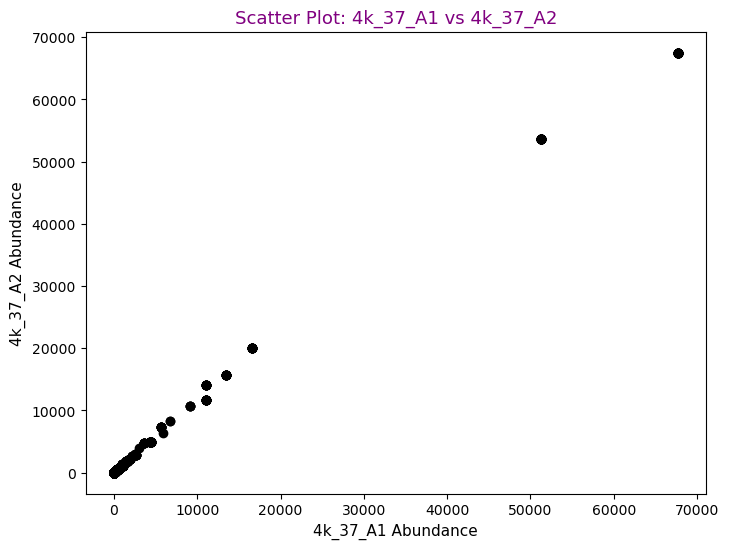

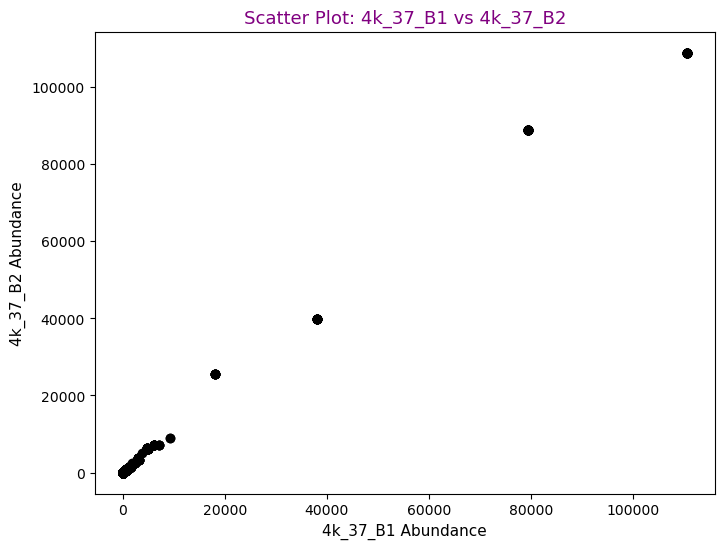

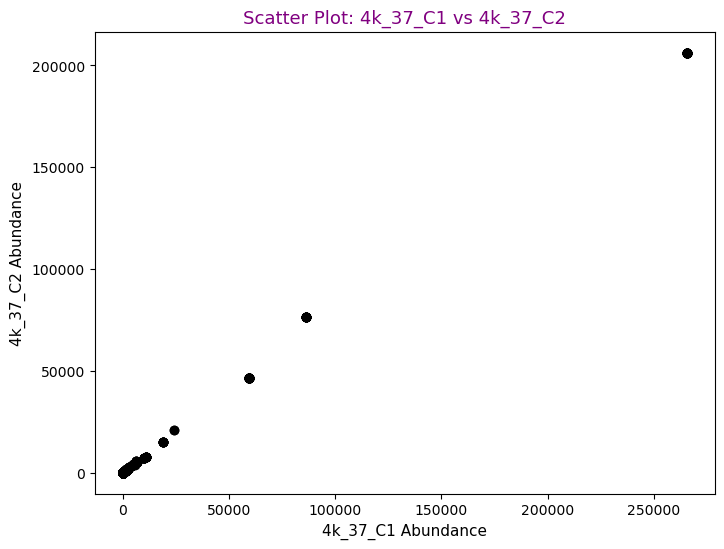

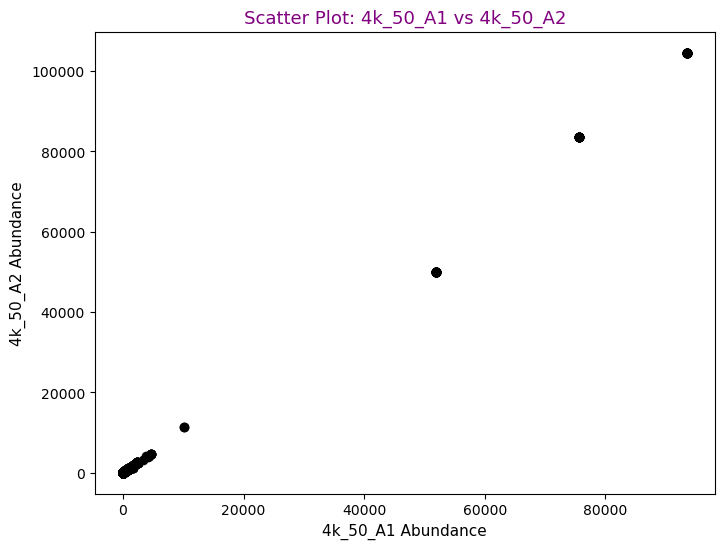

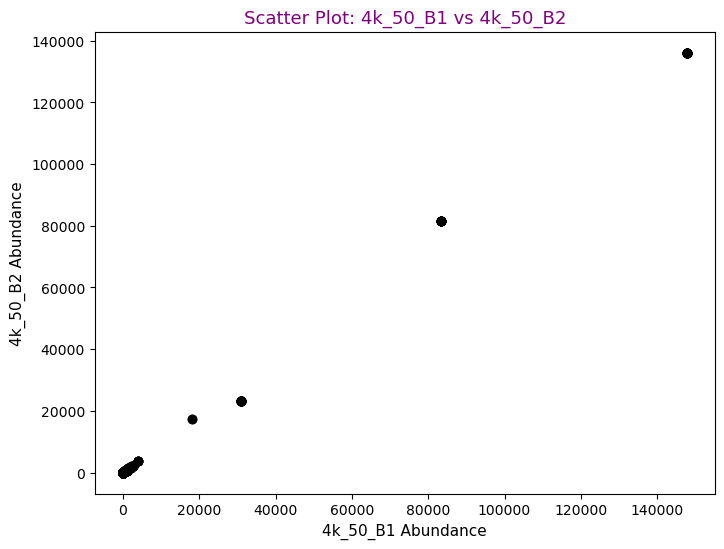

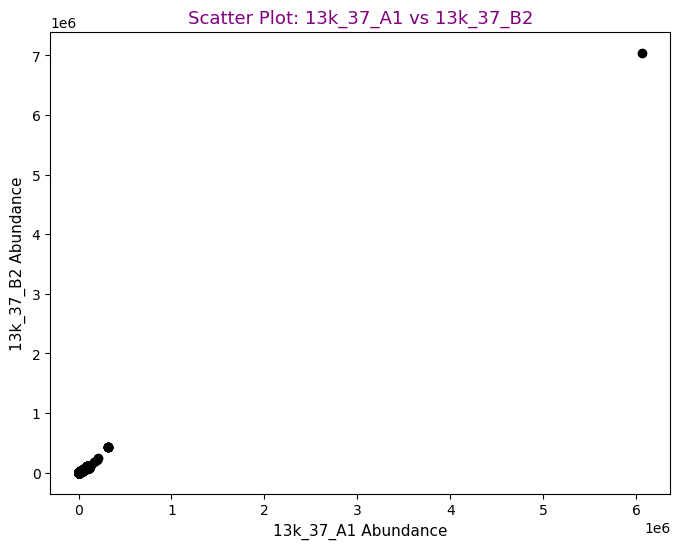

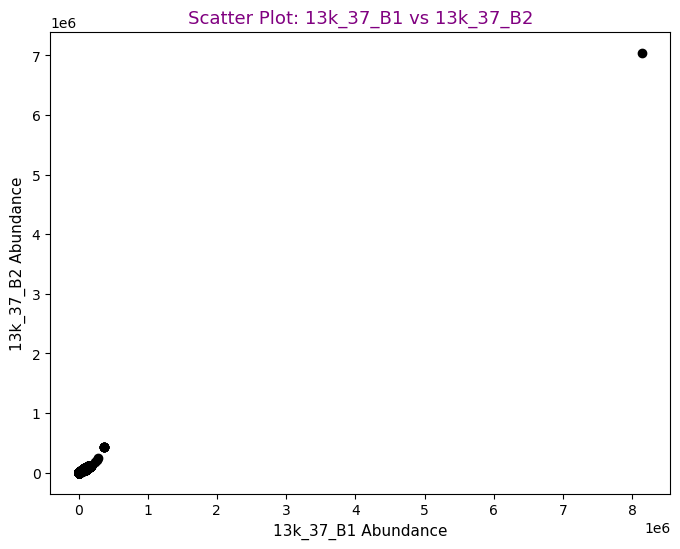

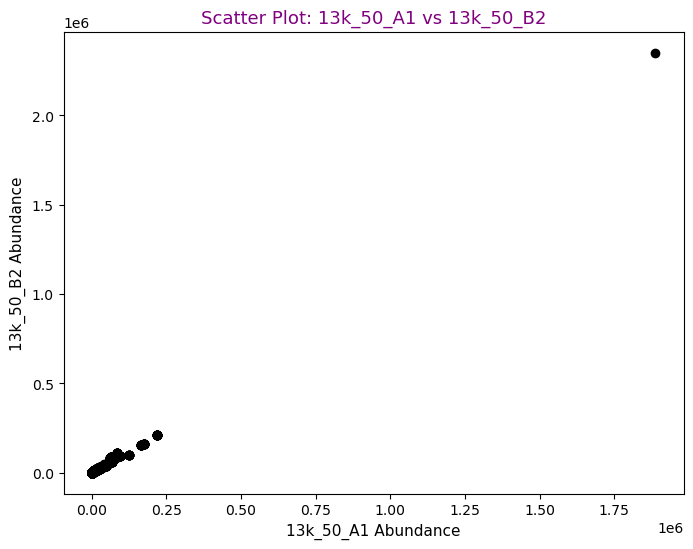

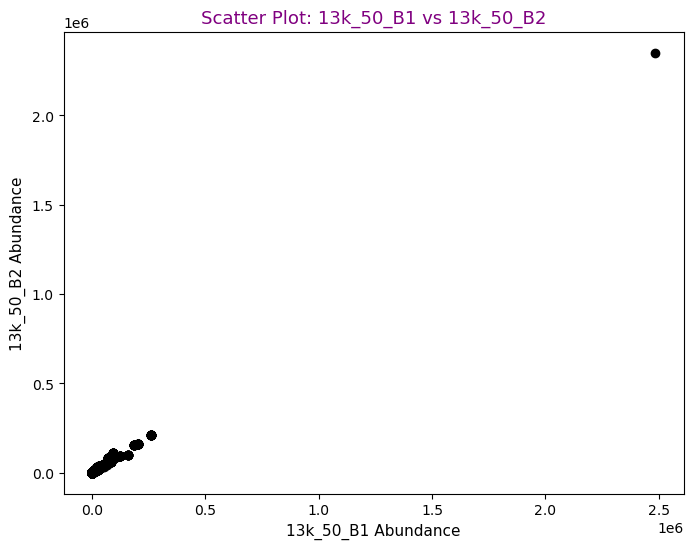

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/poolcount_4k_13k_with_promoter_paired_log2FC_RNAseq_for_use.txt', sep='\t')  # Update with your file path

# Define the pairs of columns for scatter plots
column_pairs = [
    ('4k_37_A1', '4k_37_A2'),
    ('4k_37_B1', '4k_37_B2'),
    ('4k_37_C1', '4k_37_C2'),
    ('4k_50_A1', '4k_50_A2'),
    ('4k_50_B1', '4k_50_B2'),
    ('13k_37_A1', '13k_37_B2'),
    ('13k_37_B1', '13k_37_B2'),
    ('13k_50_A1', '13k_50_B2'),
    ('13k_50_B1', '13k_50_B2')
]

# Plotting each pair of columns
for x_column, y_column in column_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    plt.show()


### Ajusting the axis of the scatter plots

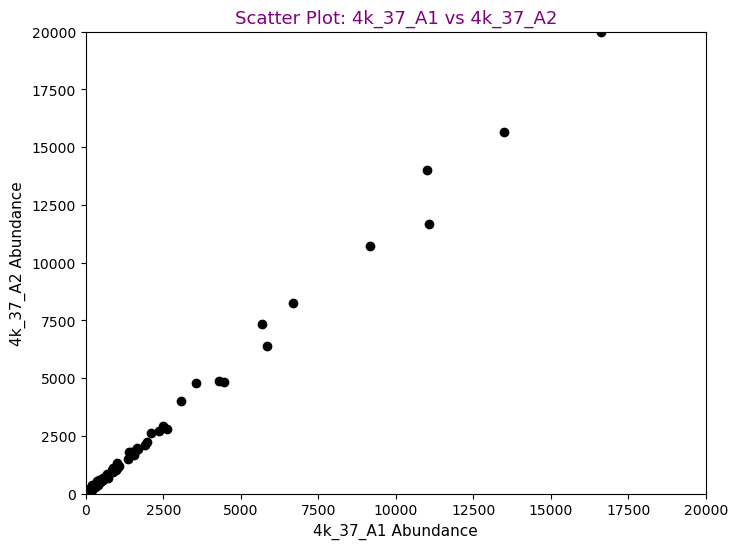

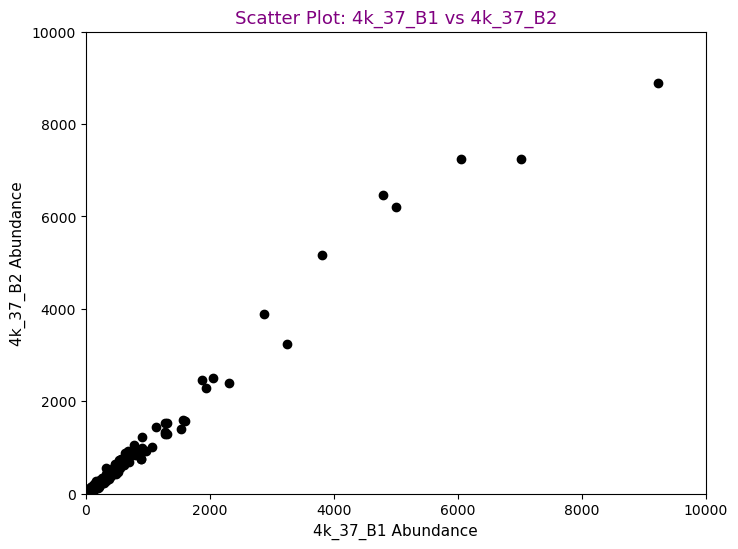

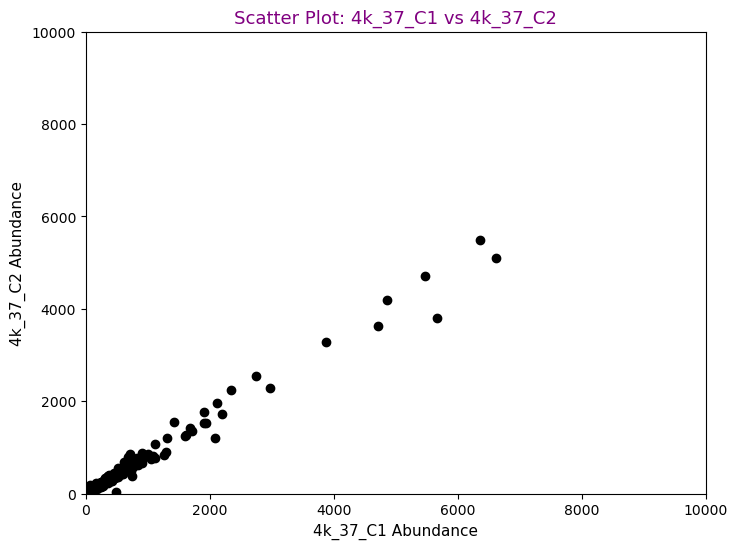

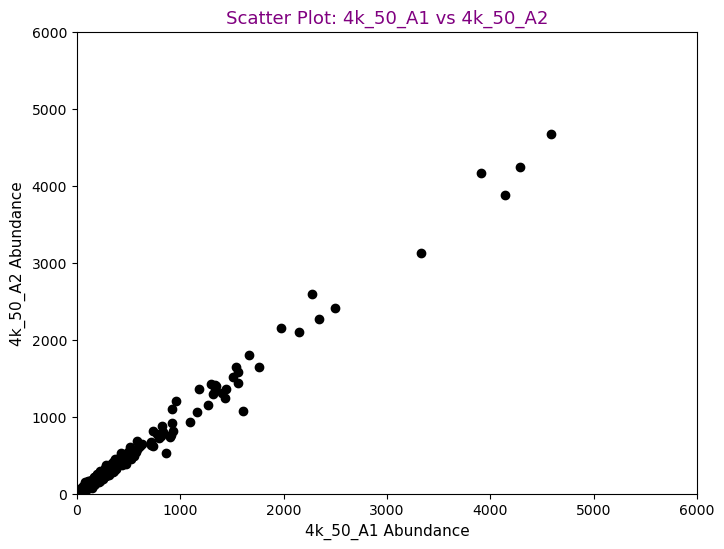

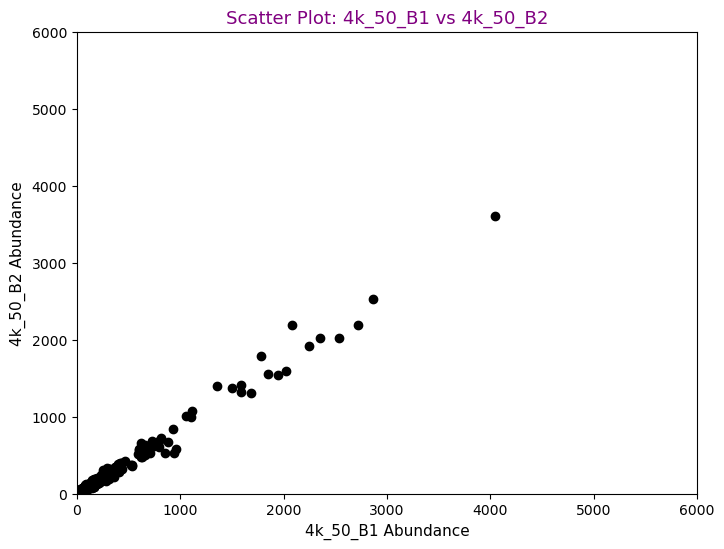

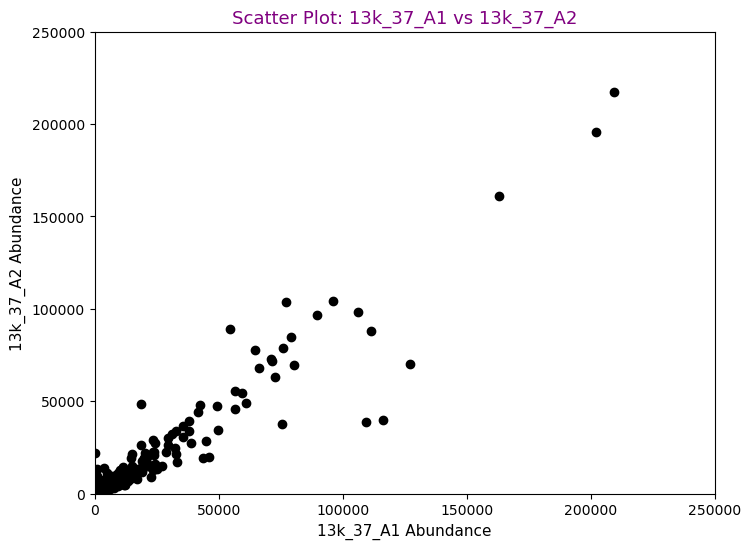

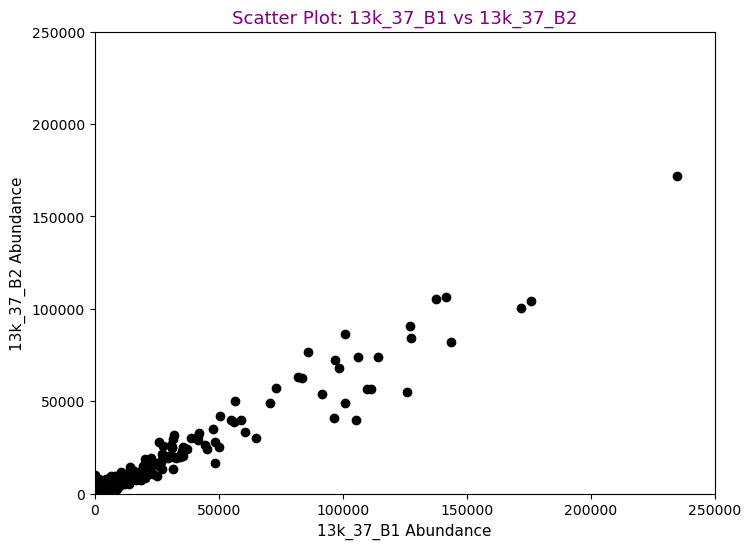

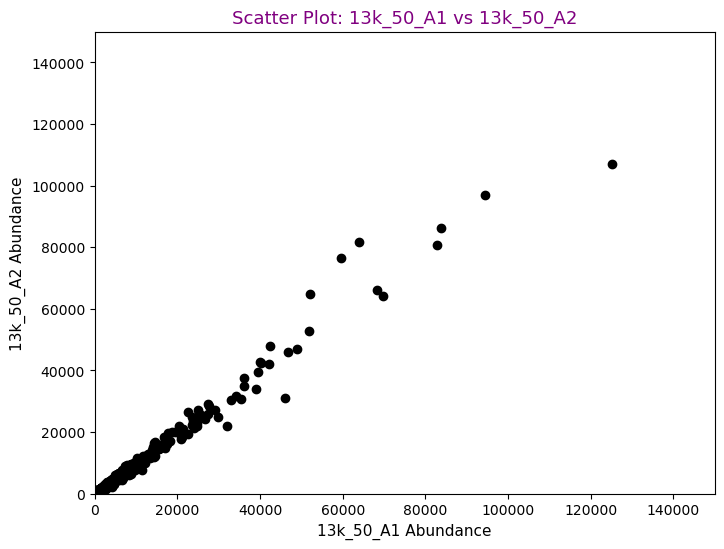

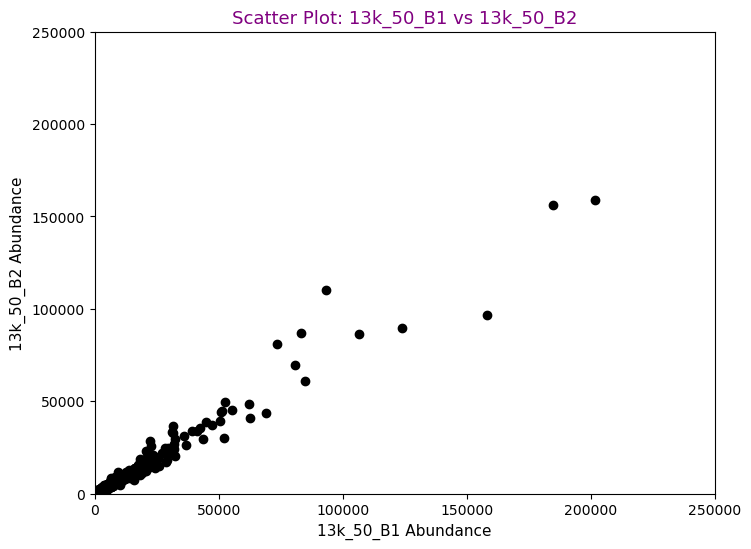

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.txt', sep='\t')  # Update with your file path

# Define the pairs of columns for scatter plots
column_pairs = [
    ('4k_37_A1', '4k_37_A2'),
    ('4k_37_B1', '4k_37_B2'),
    ('4k_37_C1', '4k_37_C2'),
    ('4k_50_A1', '4k_50_A2'),
    ('4k_50_B1', '4k_50_B2'),
    ('13k_37_A1', '13k_37_A2'),
    ('13k_37_B1', '13k_37_B2'),
    ('13k_50_A1', '13k_50_A2'),
    ('13k_50_B1', '13k_50_B2')
]


# Set custom axis limits for each pair (adjust as needed)
axis_limits = {
    '4k_37_A1_4k_37_A2': {'xlim': (0, 20000), 'ylim': (0, 20000)},
    '4k_37_B1_4k_37_B2': {'xlim': (0, 10000), 'ylim': (0, 10000)},
    '4k_37_C1_4k_37_C2': {'xlim': (0, 10000), 'ylim': (0, 10000)},
    '4k_50_A1_4k_50_A2': {'xlim': (0, 6000), 'ylim': (0, 6000)},
    '4k_50_B1_4k_50_B2': {'xlim': (0, 6000), 'ylim': (0, 6000)},
    '13k_37_A1_13k_37_A2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
    '13k_37_B1_13k_37_B2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
    '13k_50_A1_13k_50_A2': {'xlim': (0, 150000), 'ylim': (0, 150000)},
    '13k_50_B1_13k_50_B2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
}

# Plotting each pair of columns with custom axis limits
for x_column, y_column in column_pairs:
    key = f'{x_column}_{y_column}'
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    
    # Apply axis limits if available
    if key in axis_limits:
        plt.xlim(axis_limits[key]['xlim'])
        plt.ylim(axis_limits[key]['ylim'])

    plt.show()


### To calculate the r-square value and indicate on the plot

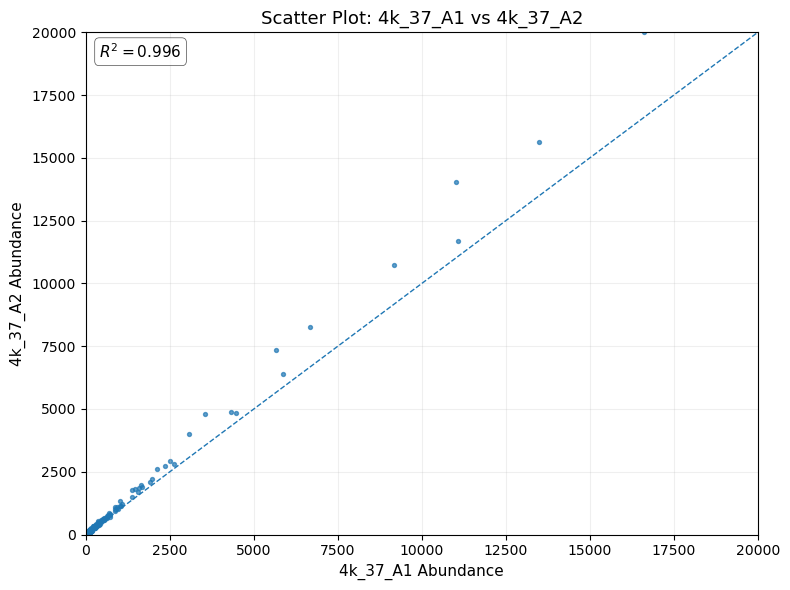

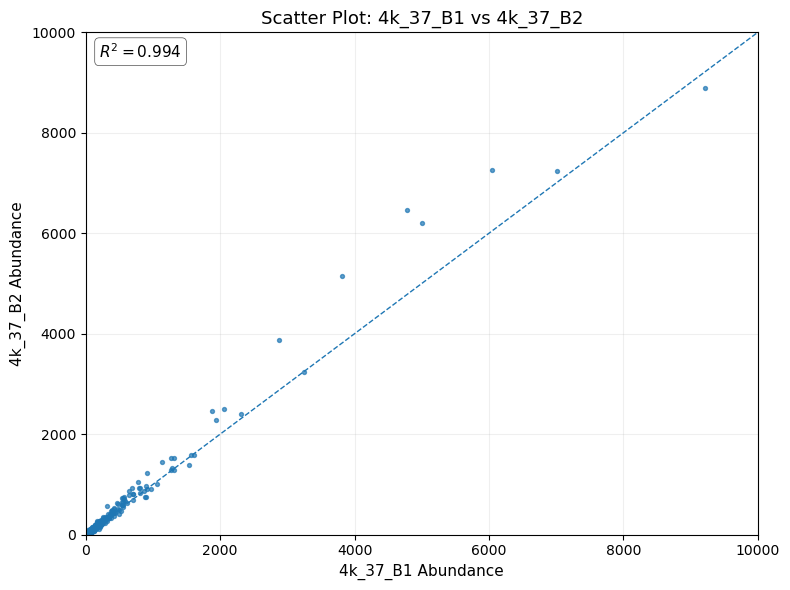

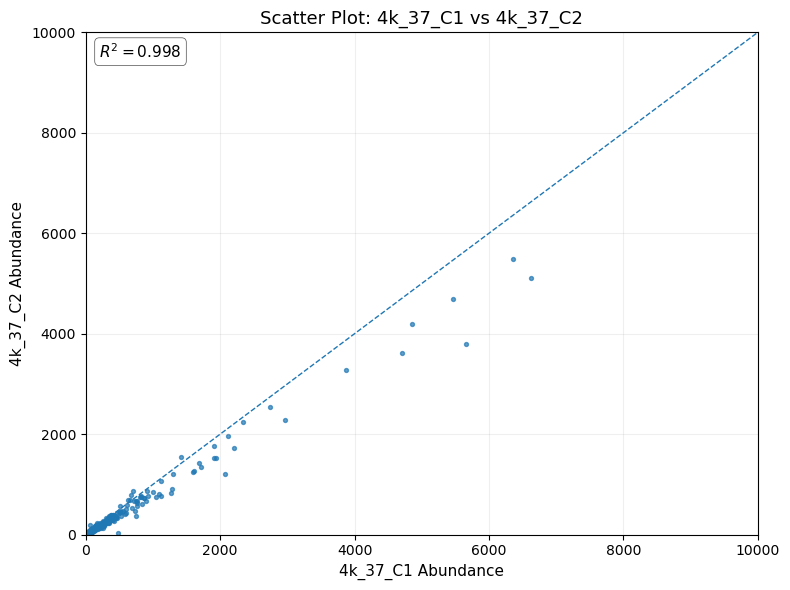

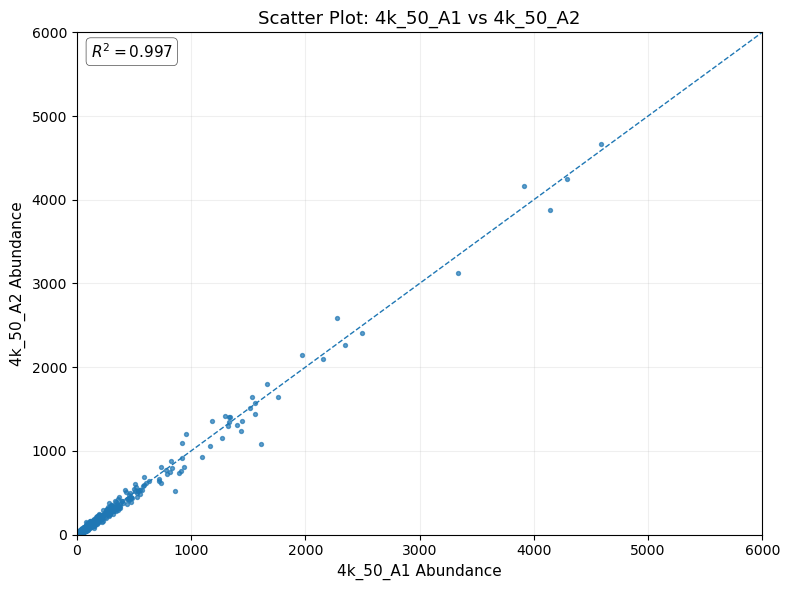

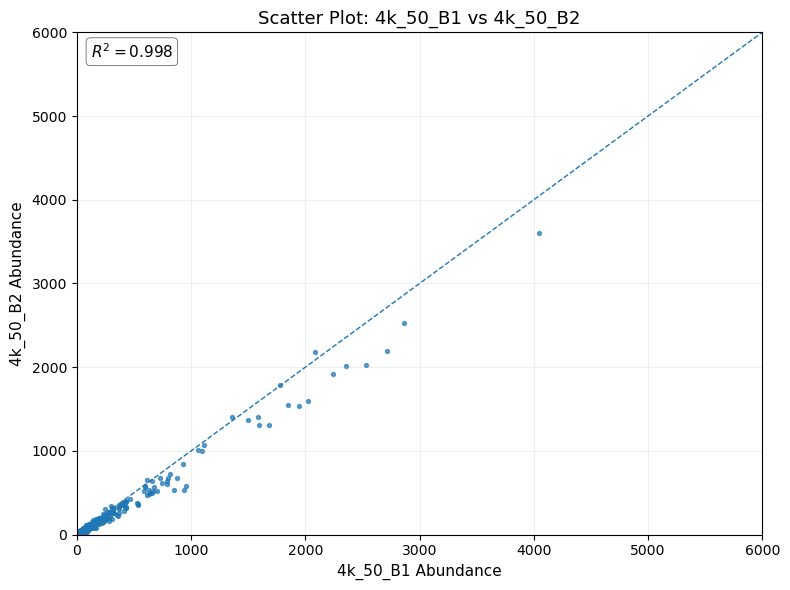

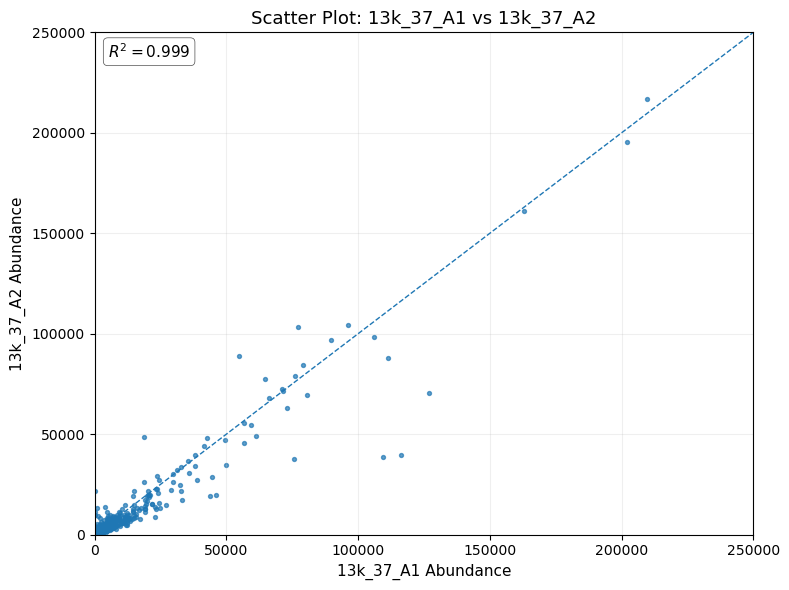

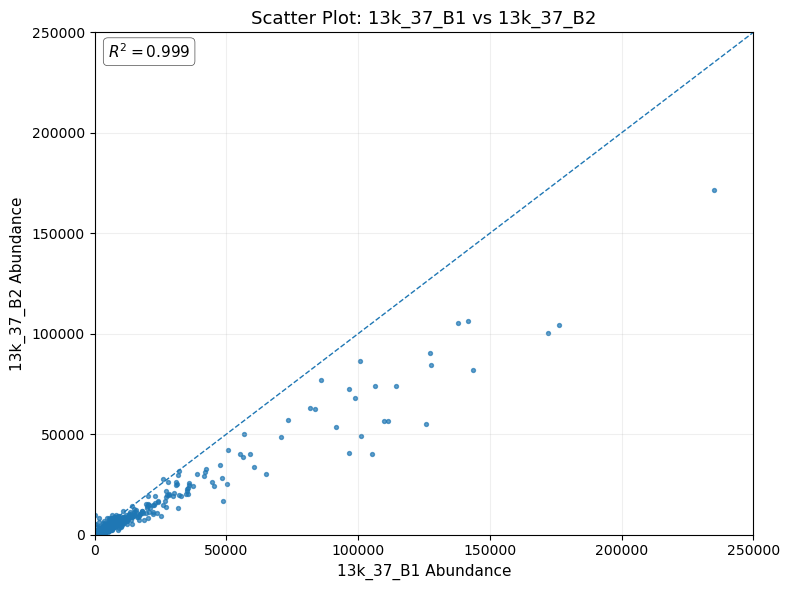

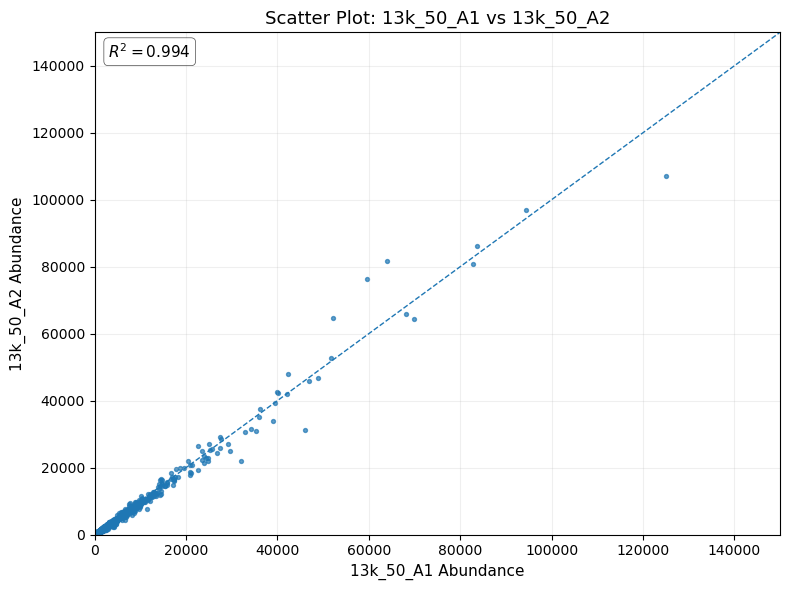

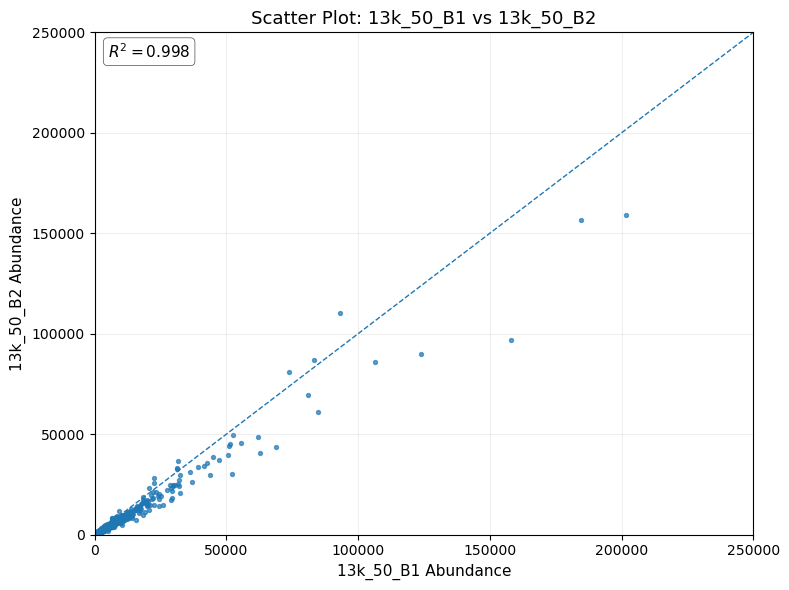

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
df = pd.read_csv(
    '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.txt',
    sep='\t'
)

# --- Column pairs (x, y) ---
column_pairs = [
    ('4k_37_A1', '4k_37_A2'),
    ('4k_37_B1', '4k_37_B2'),
    ('4k_37_C1', '4k_37_C2'),
    ('4k_50_A1', '4k_50_A2'),
    ('4k_50_B1', '4k_50_B2'),
    ('13k_37_A1', '13k_37_A2'),
    ('13k_37_B1', '13k_37_B2'),
    ('13k_50_A1', '13k_50_A2'),
    ('13k_50_B1', '13k_50_B2')
]

# --- Axis limits (optional) ---
axis_limits = {
    '4k_37_A1_4k_37_A2': {'xlim': (0, 20000),  'ylim': (0, 20000)},
    '4k_37_B1_4k_37_B2': {'xlim': (0, 10000),  'ylim': (0, 10000)},
    '4k_37_C1_4k_37_C2': {'xlim': (0, 10000),  'ylim': (0, 10000)},
    '4k_50_A1_4k_50_A2': {'xlim': (0, 6000),   'ylim': (0, 6000)},
    '4k_50_B1_4k_50_B2': {'xlim': (0, 6000),   'ylim': (0, 6000)},
    '13k_37_A1_13k_37_A2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
    '13k_37_B1_13k_37_B2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
    '13k_50_A1_13k_50_A2': {'xlim': (0, 150000), 'ylim': (0, 150000)},
    '13k_50_B1_13k_50_B2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
}

def r2_from_linear_fit(x, y):
    """Return R^2 of ordinary least squares fit y = a + b x."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:
        return np.nan
    # Fit
    b, a = np.polyfit(x, y, 1)  # slope b, intercept a
    y_pred = a + b * x
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

for xcol, ycol in column_pairs:
    key = f'{xcol}_{ycol}'
    x = pd.to_numeric(df[xcol], errors='coerce')
    y = pd.to_numeric(df[ycol], errors='coerce')

    r2 = r2_from_linear_fit(x, y)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=8, alpha=0.7)  # points

    # 1:1 reference line within current/desired limits
    # Determine limits early so the line spans the axes nicely
    if key in axis_limits:
        xlim = axis_limits[key]['xlim']
        ylim = axis_limits[key]['ylim']
    else:
        # fallback: symmetric limits based on data
        xmax = np.nanmax(x)
        ymax = np.nanmax(y)
        lim = (0, np.nanmax([xmax, ymax]) * 1.05 if np.isfinite([xmax, ymax]).any() else 1)
        xlim = ylim = lim

    plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], linestyle='--', linewidth=1)

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.xlabel(f'{xcol} Abundance', fontsize=11)
    plt.ylabel(f'{ycol} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {xcol} vs {ycol}', fontsize=13)

    # Annotate R^2 in the upper-left corner of the axes
    plt.text(
        0.02, 0.98,
        f'$R^2 = {r2:.3f}$' if np.isfinite(r2) else '$R^2$ = NA',
        transform=plt.gca().transAxes,
        ha='left', va='top', fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, lw=0.5)
    )

    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


## to normalize the Barseq pool count file based on the number of reads obtained

### this is the normalization that worked with the right result

In [33]:
import pandas as pd

# Load the CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.csv'
df = pd.read_csv(csv_file_path)

# Save the DataFrame to a text file (txt)
txt_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.txt'
df.to_csv(txt_file_path, sep='\t', index=False)


In [34]:
import pandas as pd

# Load the count file into a DataFrame
count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.txt'
df = pd.read_csv(count_file_path, sep='\t')

# Calculate the total counts for each replicate
df['Total_Count_4k_37_A1'] = df['4k_37_A1'].sum()
df['Total_Count_4k_37_A2'] = df['4k_37_A2'].sum()
df['Total_Count_4k_37_B1'] = df['4k_37_B1'].sum()
df['Total_Count_4k_37_B2'] = df['4k_37_B2'].sum()
df['Total_Count_4k_37_C1'] = df['4k_37_C1'].sum()
df['Total_Count_4k_37_C2'] = df['4k_37_C2'].sum()
df['Total_Count_4k_50_A1'] = df['4k_50_A1'].sum()
df['Total_Count_4k_50_A2'] = df['4k_50_A2'].sum()
df['Total_Count_4k_50_B1'] = df['4k_50_B1'].sum()
df['Total_Count_4k_50_B2'] = df['4k_50_B2'].sum()
df['Total_Count_13k_37_A1'] = df['13k_37_A1'].sum()
df['Total_Count_13k_37_A2'] = df['13k_37_A2'].sum()
df['Total_Count_13k_37_B1'] = df['13k_37_B1'].sum()
df['Total_Count_13k_37_B2'] = df['13k_37_B2'].sum()
df['Total_Count_13k_50_A1'] = df['13k_50_A1'].sum()
df['Total_Count_13k_50_A2'] = df['13k_50_A2'].sum()
df['Total_Count_13k_50_B1'] = df['13k_50_B1'].sum()
df['Total_Count_13k_50_B2'] = df['13k_50_B2'].sum()



# Normalize counts for each replicate by dividing by its own Total_Count
df['normalized_4k_37_A1'] = df['4k_37_A1'] / df['Total_Count_4k_37_A1']
df['normalized_4k_37_A2'] = df['4k_37_A2'] / df['Total_Count_4k_37_A2']
df['normalized_4k_37_B1'] = df['4k_37_B1'] / df['Total_Count_4k_37_B1']
df['normalized_4k_37_B2'] = df['4k_37_B2'] / df['Total_Count_4k_37_B2']
df['normalized_4k_37_C1'] = df['4k_37_C1'] / df['Total_Count_4k_37_C1']
df['normalized_4k_37_C2'] = df['4k_37_C2'] / df['Total_Count_4k_37_C2']
df['normalized_4k_50_A1'] = df['4k_50_A1'] / df['Total_Count_4k_50_A1']
df['normalized_4k_50_A2'] = df['4k_50_A2'] / df['Total_Count_4k_50_A2']
df['normalized_4k_50_B1'] = df['4k_50_B1'] / df['Total_Count_4k_50_B1']
df['normalized_4k_50_B2'] = df['4k_50_B2'] / df['Total_Count_4k_50_B2']
df['normalized_13k_37_A1'] = df['13k_37_A1'] / df['Total_Count_13k_37_A1']
df['normalized_13k_37_A2'] = df['13k_37_A2'] / df['Total_Count_13k_37_A2']
df['normalized_13k_37_B1'] = df['13k_37_B1'] / df['Total_Count_13k_37_B1']
df['normalized_13k_37_B2'] = df['13k_37_B2'] / df['Total_Count_13k_37_B2']
df['normalized_13k_50_A1'] = df['13k_50_A1'] / df['Total_Count_13k_50_A1']
df['normalized_13k_50_A2'] = df['13k_50_A2'] / df['Total_Count_13k_50_A2']
df['normalized_13k_50_B1'] = df['13k_50_B1'] / df['Total_Count_13k_50_B1']
df['normalized_13k_50_B2'] = df['13k_50_B2'] / df['Total_Count_13k_50_B2']

# Save the normalized count file
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.csv'
df.to_csv(normalized_count_file_path, index=False)


##### To make the fitness abundance agaian using the normalized values

In [35]:
import pandas as pd

# Load the CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.csv'
df = pd.read_csv(csv_file_path)

# Save the DataFrame to a text file (txt)
txt_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.txt'
df.to_csv(txt_file_path, sep='\t', index=False)


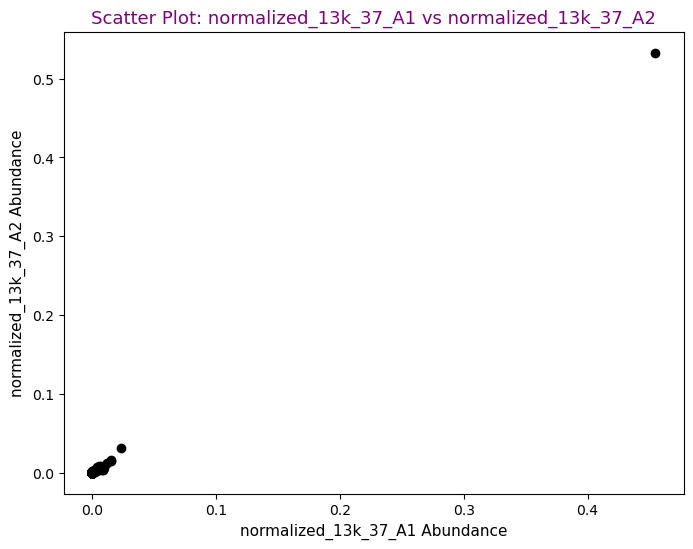

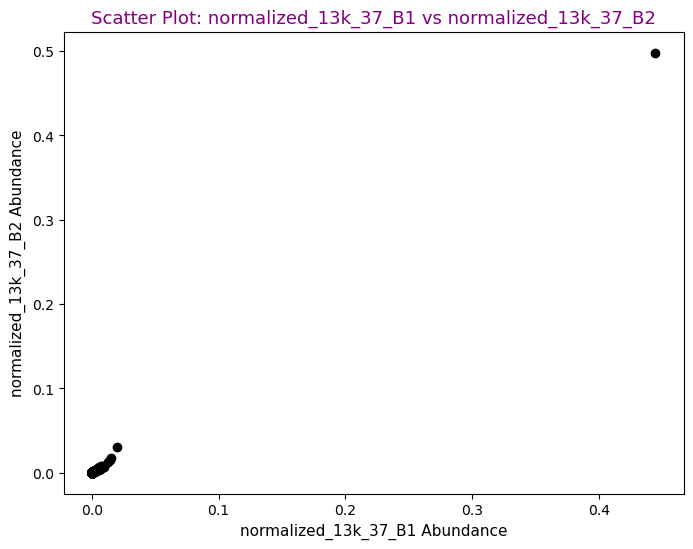

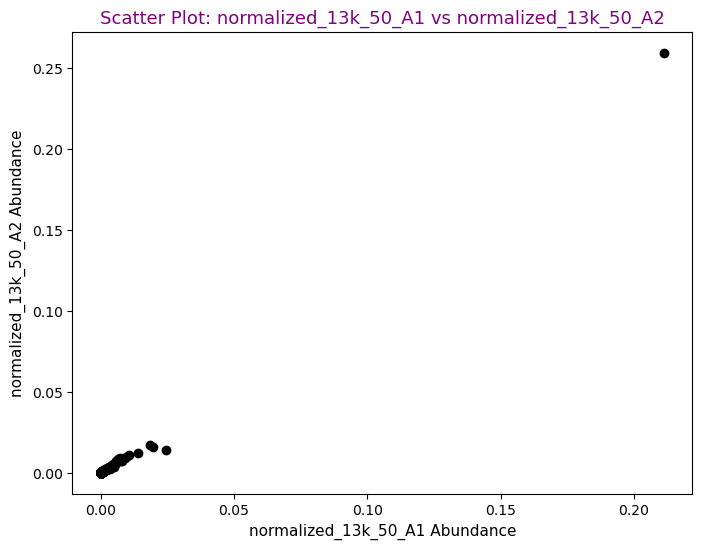

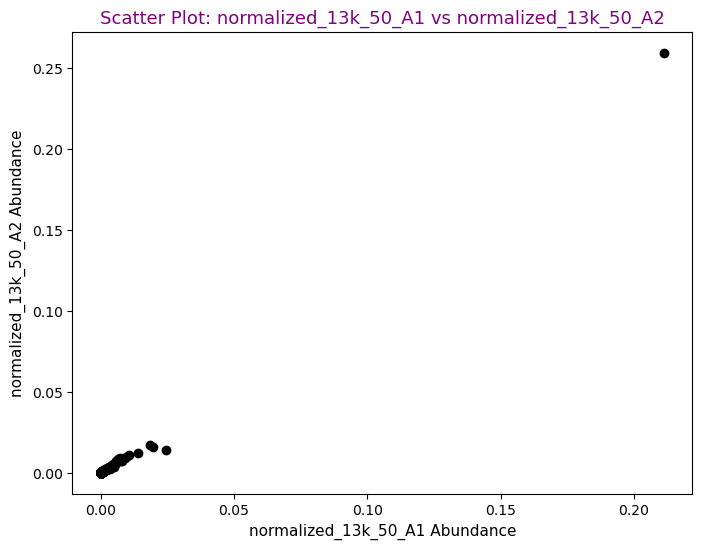

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.txt', sep='\t')

# Define the pairs of columns for scatter plots
column_pairs = [
    ('normalized_13k_37_A1', 'normalized_13k_37_A2'),
    ('normalized_13k_37_B1', 'normalized_13k_37_B2'),
    ('normalized_13k_50_A1', 'normalized_13k_50_A2'),
    ('normalized_13k_50_A1', 'normalized_13k_50_A2')
]

# Plotting each pair of columns
for x_column, y_column in column_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.txt', sep='\t')

# Define the pairs of columns and their axis limits for scatter plots
column_pairs = [
    ('normalized_37_A1', 'normalized_37_A2'),
    ('normalized_37_B1', 'normalized_37_B2'),
    ('normalized_50_A1', 'normalized_50_A2'),
    ('normalized_50_B1', 'normalized_50_B2')
]

# Set custom axis limits for each pair (adjust as needed)
axis_limits = {
    'normalized_37_A1_normalized_37_A2': {'xlim': (0, 0.02), 'ylim': (0, 0.025)},
    'normalized_37_B1_normalized_37_B2': {'xlim': (0, 0.02), 'ylim': (0, 0.025)},
    'normalized_50_A1_normalized_50_A2': {'xlim': (0, 0.02), 'ylim': (0, 0.02)},
    'normalized_50_B1_normalized_50_B2': {'xlim': (0, 0.02), 'ylim': (0, 0.02)}
}

# Plotting each pair of columns with custom axis limits
for x_column, y_column in column_pairs:
    key = f'{x_column}_{y_column}'
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    
    # Apply axis limits if available
    if key in axis_limits:
        plt.xlim(axis_limits[key]['xlim'])
        plt.ylim(axis_limits[key]['ylim'])

    plt.show()


# To do statistical t-test

### To handle rows where some values are zero and convert them to NaN before performing the Mann-Whitney U test

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# Load the dataset
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_promoter_paired_log2FC_RNAseq_final_corrected.csv')

# Convert all columns to numeric, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace zeros with NaN
df.replace(0, np.nan, inplace=True)

# Define the data columns for the existing and new conditions
data_37C = df[['normalized_4k_37_A1', 'normalized_4k_37_A2', 'normalized_4k_37_B1', 'normalized_4k_37_B2', 'normalized_4k_37_C1', 'normalized_4k_37_C2', 'normalized_13k_37_A1', 'normalized_13k_37_A2', 'normalized_13k_37_B1', 'normalized_13k_37_B2']]
data_50C = df[['normalized_4k_50_A1', 'normalized_4k_50_A2', 'normalized_4k_50_B1', 'normalized_4k_50_B2', 'normalized_13k_50_A1', 'normalized_13k_50_A2', 'normalized_13k_50_B1', 'normalized_13k_50_B2']]
            



# List to store p-values for existing conditions
p_values_37_vs_50 = []

# Iterate over rows and perform Mann-Whitney U test for each
for index, row in df.iterrows():
    # Drop NaN values from the datasets
    data_37C_values = row[data_37C.columns].dropna()
    
    

    # Perform the Mann-Whitney U test for 37C vs. 50C
    #data_37C_values = row[data_25C.columns].dropna()
    data_50C_values = row[data_50C.columns].dropna()

    if len(data_37C_values) > 0 and len(data_50C_values) > 0:
        statistic, p_value = mannwhitneyu(data_37C_values, data_50C_values, alternative='two-sided')
        p_values_37_vs_50.append(p_value)
    else:
        p_values_37_vs_50.append(np.nan)

# Add the p-values to the DataFrame

df['MannWhitneyU_p_value_37_vs_50'] = p_values_37_vs_50

# Save the DataFrame with the calculated p-values to a new CSV file
output_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_4k_plus_13k_mutants/for_analysis/pool_fastqs_available/TNSeq_barseq_recounted_outputs_using_all_fastqs_combined_4k_plus_13k_mutants_37•C_vs_50•C_01_24_2025_finalized_3/normalized_poolcount_4k_13k_with_promoter_paired_log2FC_RNAseq_for_use_37C_vs_50C_output_with_mannwhitneyu_p_values_zero_values_removed_combined.csv'
df.to_csv(output_path, index=False)
